**IMPORTS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.tree import export_text, plot_tree
import joblib
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import _tree
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load the data
df = pd.read_csv('./data/train_data.csv')
df.head(2)

,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food,Offer Accepted
0,2days,₹100000 or More,4~8,1,less1,Married partner,4 star restaurant,36,0,0,...,0,0,4,67,less1,22,Spring,Location B,0,No
1,2days,₹87500 - ₹99999,4~8,0,4~8,Married partner,Take-away restaurant,50plus,0,0,...,0,1,3,89,1~3,18,Summer,Location B,0,Yes


**EDA**

**X-Y SPLIT**

In [3]:
def separate_columns(df):
    # Separate numerical and categorical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=[object]).columns.tolist()

    # Further separate categorical columns into binary and multi-category columns
    binary_cols = [col for col in categorical_cols if df[col].nunique() == 2]
    multi_cols = [col for col in categorical_cols if df[col].nunique() > 2]

    return numeric_cols, categorical_cols, binary_cols, multi_cols


In [4]:
# Split the dataset into features and target variable
X = df.drop('Offer Accepted', axis=1)
y = df['Offer Accepted'].replace({'Yes': 1, 'No': 0})
numeric_cols, categorical_cols, binary_cols, multi_cols = separate_columns(X)
# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**PREPROCESSING**

In [5]:
# Define the preprocessing steps for both types of features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

# Group the preprocessing steps together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('binary', binary_transformer, binary_cols)
    ]
)


In [6]:
# Define the models
models = [
    ('rf', RandomForestClassifier()), 
    ('dt', DecisionTreeClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('xgb', XGBClassifier()),
]


In [7]:
# Define the pipelines
pipelines = []
for name, model in models:
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          (name, model)])
    pipelines.append((name, clf))
print(pipelines[0][1][1])

RandomForestClassifier()


**INITIAL MODEL TRAINING & PERFORMANCE**

In [8]:
# Train the models and evaluate
model_performance = []
for name, pipeline in pipelines:
    # Fit the pipeline on the training data
    model = pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Compute metrics of the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion = confusion_matrix(y_test, y_pred)

    # Store the metrics and model parameters
    model_performance.append({
        'modelname': name, 
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1_score': f1, 
        'confusion_matrix': confusion,
        'parameters': model.get_params()
    })

# Create DataFrame from the model performance data
df_performance = pd.DataFrame(model_performance)

perf_dir = "./performance-reports"
# Create directories if they do not exist
os.makedirs(perf_dir, exist_ok=True)
# Save DataFrame to an Excel file
df_performance.to_excel("./performance-reports/initial-model-performance.xlsx")


**DEFINE HYPERPARAMETERS & PLOTTING FUNCTIONS**

In [9]:
# Define a list to store the performance of the models after hyperparameter tuning
tuned_model_performance = []

# Define a dictionary with hyperparameters for each model
# Note: These are just examples. You should define the hyperparameters based on your knowledge of each model.
hyperparameters = {
    'rf': {
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [15],#[None, 5, 15],
        'rf__min_samples_split': [2, 5],
    },
    'dt': {
        'dt__max_depth': [15],# [None, 5, 15],
        'dt__min_samples_split': [2, 5],
        'dt__criterion': ['gini', 'entropy', 'log_loss']
    },
    'gb': {
        'gb__n_estimators': [100, 500, 1000],
        'gb__learning_rate': [0.001, 0.01], #[10, 100]
        'gb__max_depth': [15],#[10, 15],#[5, 10],
        # 'gb__max_features': [None, 'auto', 'sqrt', 'log2'],
        'gb__max_features': ['sqrt']
    },
    'xgb': {
        'xgb__n_estimators': [100, 500],
        'xgb__learning_rate': [0.001, 0.01, 0.1],    #[10, 100]
        'xgb__max_depth': [10]#[5, 10]
    }
}


In [10]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig(f'./plots/{model_name}_confusion_matrix.png')
    plt.close()
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')
    plt.savefig(f'./plots/{model_name}_roc_curve.png')
    plt.close()
def plot_precision_recall_curve(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig(f'./plots/{model_name}_precision_recall_curve.png')
    plt.close()


**EXECUTE HPT AND PLOTTING PERFORMANCE METRICES OF TOP 3 MODELS**

In [126]:
# Filter the models based on the F1 score threshold
filtered_models = df_performance[df_performance['f1_score'] >= 0.59]

# Perform hyperparameter tuning for the models that passed the filter
for idx, row in filtered_models.iterrows():
    print(f"For {row['modelname']}:------------------------")
    # Define the model pipeline
    model_pipeline = [pipeline for name, pipeline in pipelines if name == row['modelname']][0]
    
    # Define the hyperparameters for this model
    model_hyperparameters = hyperparameters.get(row['modelname'], {})
    
    # Define the grid search for hyperparameter tuning
    grid_search = GridSearchCV(model_pipeline, model_hyperparameters, cv=5, scoring='f1_weighted')
    
    # Fit the grid search on the training data
    grid_search.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = grid_search.predict(X_test)
    
    
    # Compute metrics of the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion = confusion_matrix(y_test, y_pred)
    
    # Store the metrics and model parameters
    tuned_model_performance.append({
        'modelname': row['modelname'], 
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1_score': f1, 
        'confusion_matrix': confusion,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    })

    # Save the best model as a .pkl file
    model_filename = f"./models/{row['modelname']}-model.pkl"
    os.makedirs('./models', exist_ok=True)
    joblib.dump(grid_search.best_estimator_, model_filename)
    print(f"Saved {row['modelname']} model to {model_filename}")
    
    os.makedirs('./plots', exist_ok=True)
    
    y_prob = model.predict_proba(X_test)[:, 1]
    model_name = row['modelname']
    plot_confusion_matrix(y_test, y_pred, model_name)
    plot_roc_curve(y_test, y_prob, model_name)
    plot_precision_recall_curve(y_test, y_prob, model_name)
    print()


# Create DataFrame from the model performance data
df_tuned_performance = pd.DataFrame(tuned_model_performance)

perf_dir = "./performance-reports"
# Create directories if they do not exist
os.makedirs(perf_dir, exist_ok=True)
# Save DataFrame to an Excel file
df_tuned_performance.to_excel("./performance-reports/tuned-model-performance.xlsx")


For rf:------------------------
Saved rf model to ./models/rf-model.pkl

For gb:------------------------
Saved gb model to ./models/gb-model.pkl

For xgb:------------------------
Saved xgb model to ./models/xgb-model.pkl



**TUNED MODEL PERFORMANCE ANALYSIS**

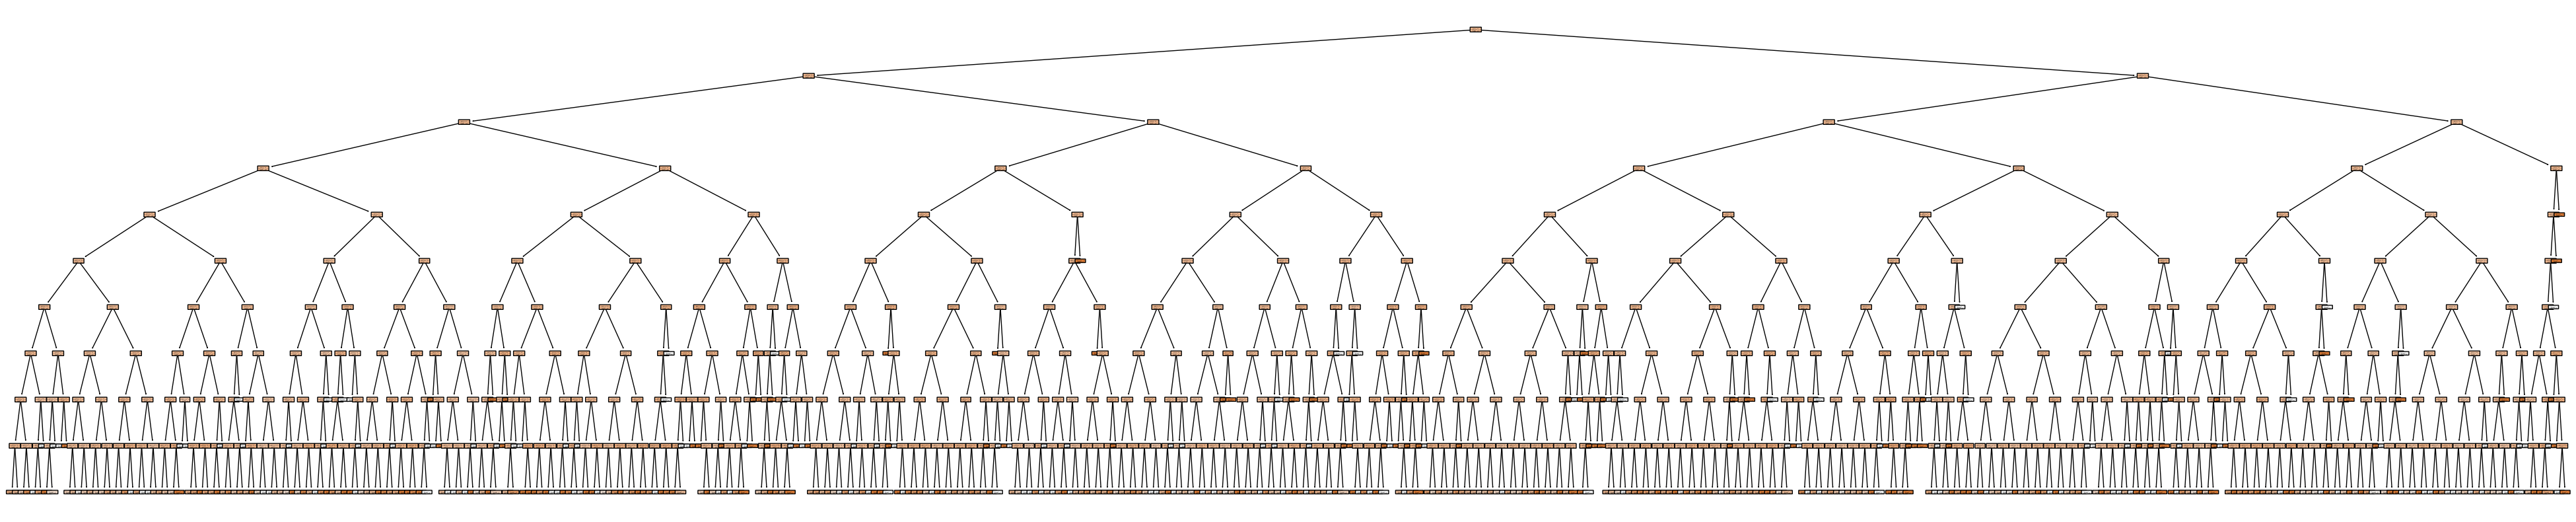

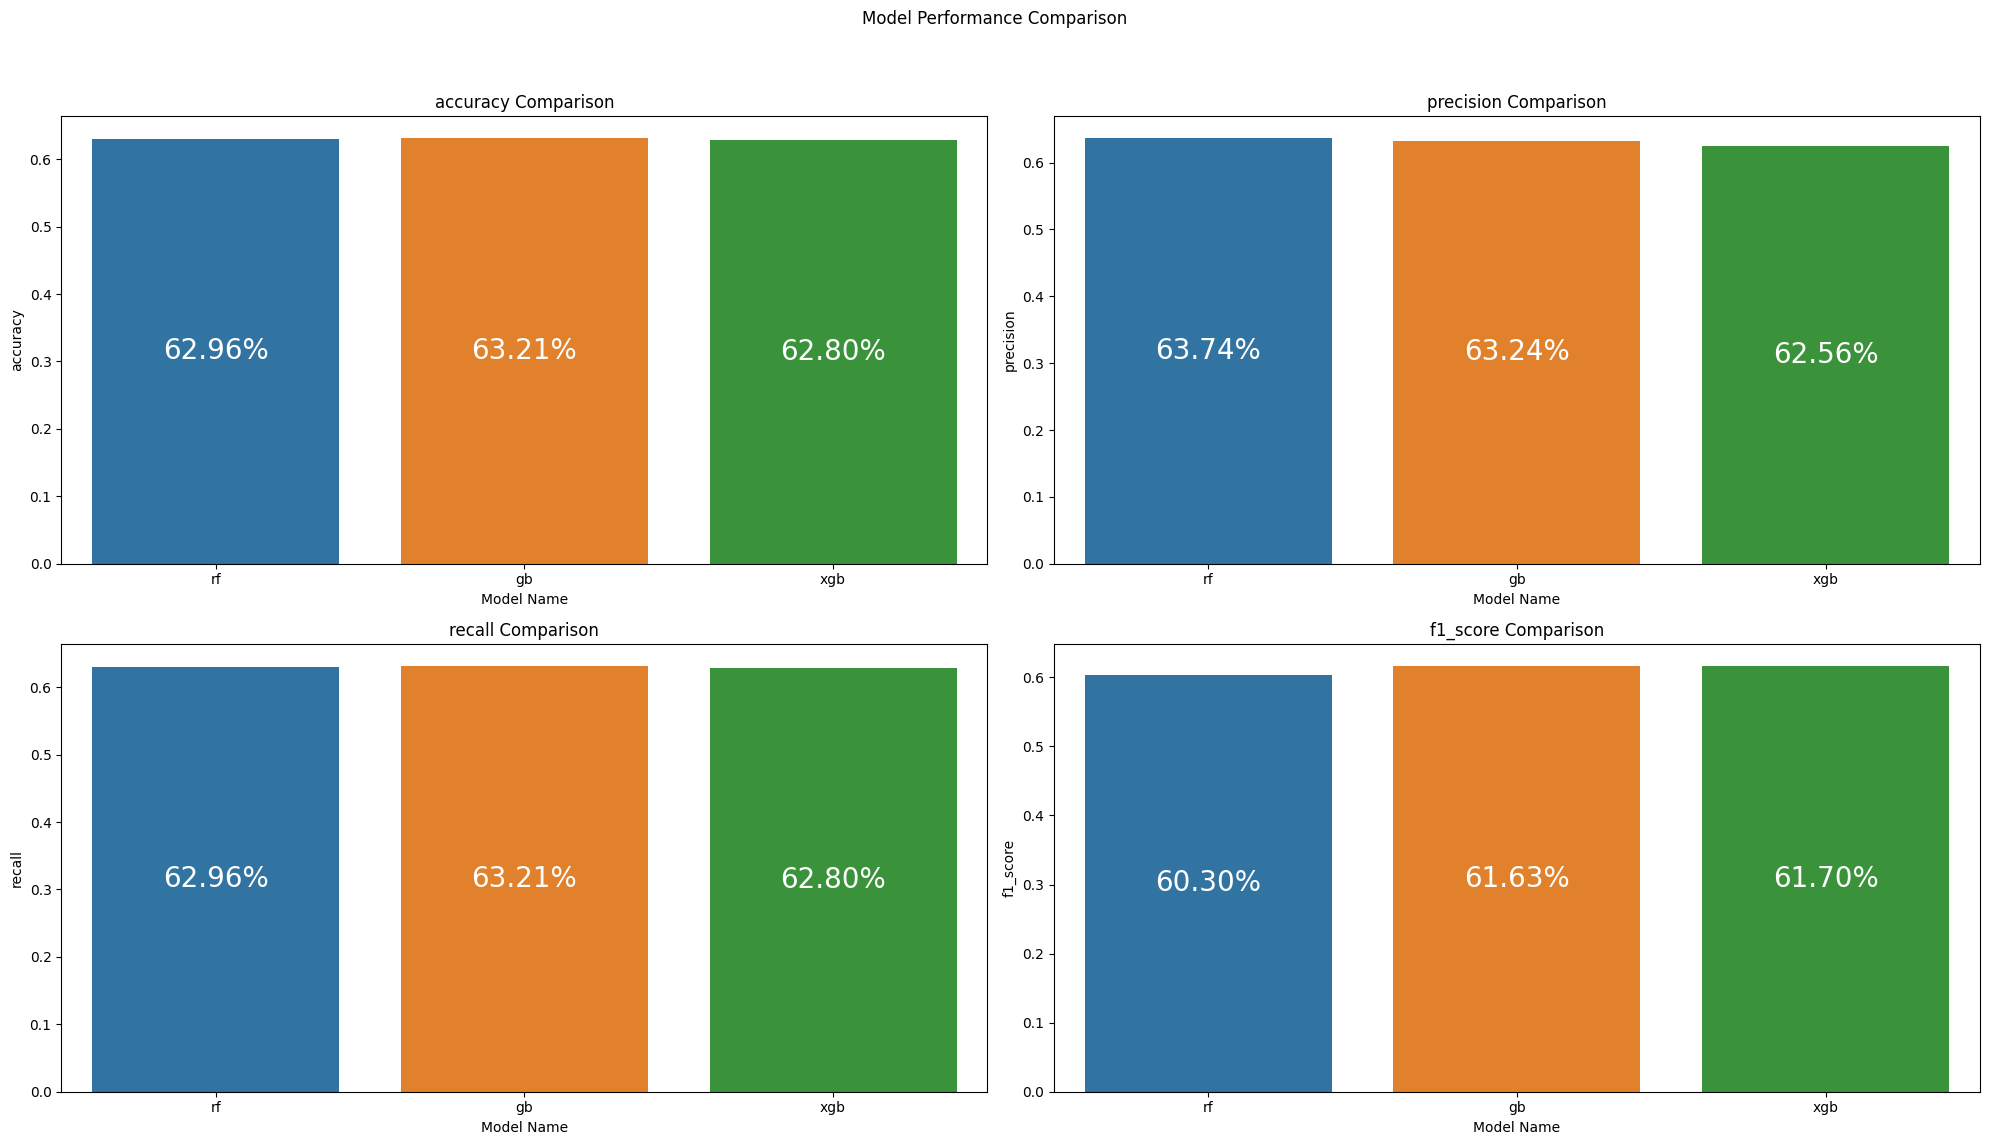

In [127]:
# Read the Excel file
tuned_model_performance_df = pd.read_excel("./performance-reports/tuned-model-performance.xlsx")

# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Model Performance Comparison')

# Define metrics to plot
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

# Iterate through metrics and axes to plot subplots
for metric, ax in zip(metrics, axes.flatten()):
    sns.barplot(x='modelname', y=metric, data=tuned_model_performance_df, ax=ax)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Model Name')
    ax.set_ylabel(metric)
    
    # Adding percentage value on top of each bar
    # Adding percentage value inside each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height() * 100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                    ha='center', va='center', fontsize=20, color='white', xytext=(0, 0),
                    textcoords='offset points')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Result:-**
- Analysing Tuned Performance of different models, we see that `Gradient Boosting` & `XGBoost` gives best Result.
- Now, we'll move forward with `XGB`.

**TRAINING FINAL MODEL WITH BEST PARAMS ON ENTIRE DATASET**

In [28]:
# tuned_model_performance

In [128]:
# Combine the training and test data
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

modelname = 'xgb'   #'gb'
# Retrieve the best hyperparameters for the Gradient Boosting model from the tuned performance
best_params = [record['best_params'] for record in tuned_model_performance if record['modelname'] == modelname][0]

# Remove the 'gb__' prefix from the hyperparameters
final_hyperparams = {key.replace(f'{modelname}__', ''): value for key, value in best_params.items()}

# Define the final Gradient Boosting model with the best hyperparameters
final_model = GradientBoostingClassifier(**final_hyperparams)

# Final pipeline including preprocessing and GB model
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessor defined earlier in your code
    (f'{modelname}', final_model)
])

# Train the final pipeline on the full dataset (X_full, y_full)
final_pipeline.fit(X_full, y_full)

# Save the final pipeline as a pickle file
joblib.dump(final_pipeline, f'./models/final_{modelname}_model.pkl')

print(f"Final {modelname} pipeline trained and saved.")


Final xgb pipeline trained and saved.


In [131]:
# Print the hyperparameters used in the final model
final_model_params = final_model.get_params()
print(f"Hyperparameters used in the final {modelname} model:")
for key, value in final_model_params.items():
    print(f"{key}: {value}")

# Print the best hyperparameters from HPT (without 'gb__' prefix)
print("\nBest hyperparameters from Hyperparameter Tuning:")
for key, value in final_hyperparams.items():
    print(f"{key}: {value}")

# Compare and check if they match
if all(final_model_params[key] == value for key, value in final_hyperparams.items()):
    print("\nThe hyperparameters in the final model match the best hyperparameters from HPT.")
else:
    print("\nThere is a mismatch between the hyperparameters in the final model and the best hyperparameters from HPT.")


Hyperparameters used in the final xgb model:
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.01
loss: log_loss
max_depth: 10
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 500
n_iter_no_change: None
random_state: None
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False

Best hyperparameters from Hyperparameter Tuning:
learning_rate: 0.01
max_depth: 10
n_estimators: 500

The hyperparameters in the final model match the best hyperparameters from HPT.


**TREE ANALYSIS**

In [132]:
# Get the preprocessor from the pipeline
transformed_feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)

# Extract the Gradient Boosting model (final_gb_model) from the above steps
# Choose the first tree from the ensemble (you can choose any tree by changing the index)
tree_model = final_model.estimators_[0, 0]

os.makedirs('./tree-representations', exist_ok=True)

# # Plot the tree
# plt.figure(figsize=(50, 10))
# plot_tree(tree_model, feature_names=transformed_feature_names, filled=True, rounded=True)
# plt.savefig('./tree-representations/gb-tree.png', dpi=700)

# Plot the tree without specifying feature names
plt.figure(figsize=(50, 10))
plot_tree(tree_model, filled=True, rounded=True)
plt.savefig(f'./tree-representations/{modelname}-tree.png', dpi=700)

# Function to extract tree structure (same as your code)
def extract_tree_structure(tree, feature_names):
    # Initialize an empty dataframe to store the tree structure
    df = pd.DataFrame(columns=['node_id', 'feature', 'threshold', 'left_child', 'right_child'])

    # Recursive function to visit each node and extract information
    def recurse(node_id):
        # If we're at a leaf node (no children), return
        if tree.children_left[node_id] == _tree.TREE_LEAF:
            return

        # Extract feature name, threshold, and children from the tree
        feature = feature_names[tree.feature[node_id]]
        threshold = tree.threshold[node_id]
        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]

        # Append the node information to the dataframe
        df.loc[node_id] = [node_id, feature, threshold, left_child, right_child]
        # Recurse on the children of the node
        recurse(left_child)
        recurse(right_child)
    # Start recursion from the root of the tree (node 0)
    recurse(0)
    return df

# Call the function on your tree
tree = tree_model.tree_
df_tree_structure = extract_tree_structure(tree, transformed_feature_names)

# Save the DataFrame to an Excel file
df_tree_structure.to_excel(f'./tree-representations/{modelname}-tree_structure.xlsx')

print(f"{modelname} tree structure saved.")


xgb tree structure saved.


**SHAP ANALYSIS AND BUSINESS STRATEGY**

In [133]:
# Transform the full dataset using the preprocessor
X_full_transformed = preprocessor.transform(X_full)

# Convert the transformed data into a DataFrame
transformed_feature_names = preprocessor.get_feature_names_out(input_features=X.columns)
X_full_transformed_df = pd.DataFrame(X_full_transformed, columns=transformed_feature_names)

# Create an explainer for the Gradient Boosting model
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_full_transformed_df)

# Initialize JavaScript visualization code (for Jupyter Notebooks)
shap.initjs()

# Check the dimension of the SHAP values array and visualize
if len(shap_values.shape) == 2:
    shap.force_plot(explainer.expected_value[0], shap_values[0,:], X_full_transformed_df.iloc[0,:], show=False, matplotlib=True).savefig(f'./shap-analysis/{modelname}_shap_plot.png')
else:
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_full_transformed_df.iloc[0,:], show=False, matplotlib=True).savefig(f'./shap-analysis/{modelname}_shap_plot.png')

print(f"{modelname} SHAP plot saved.")

# Convert the SHAP values to a DataFrame and save to an Excel file
shap_values_df = pd.DataFrame(shap_values, columns=X_full_transformed_df.columns)
shap_values_df.to_excel(f'./shap-analysis/{modelname}_shap_values.xlsx')
print(f"{modelname} SHAP Excel File saved.")

# Print the base value
print(f'Base value of {modelname}:', explainer.expected_value)


xgb SHAP plot saved.
xgb SHAP Excel File saved.
Base value of xgb: [0.32815688]


- Analyse SHAP Values, Create Viz in Excel / Power BI
- Create Business Strategy Dashboard

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


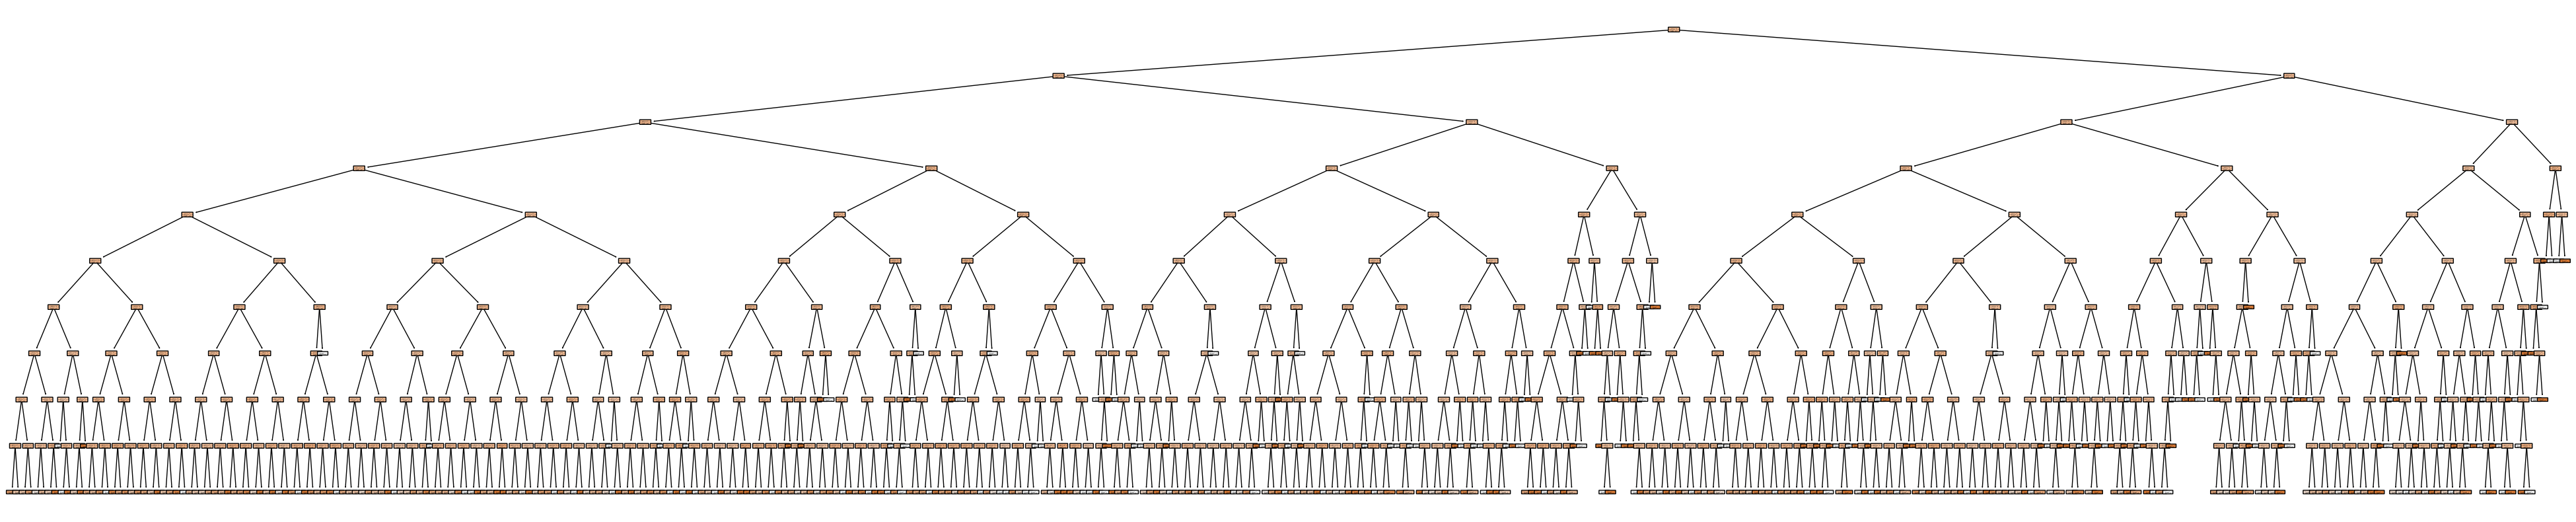

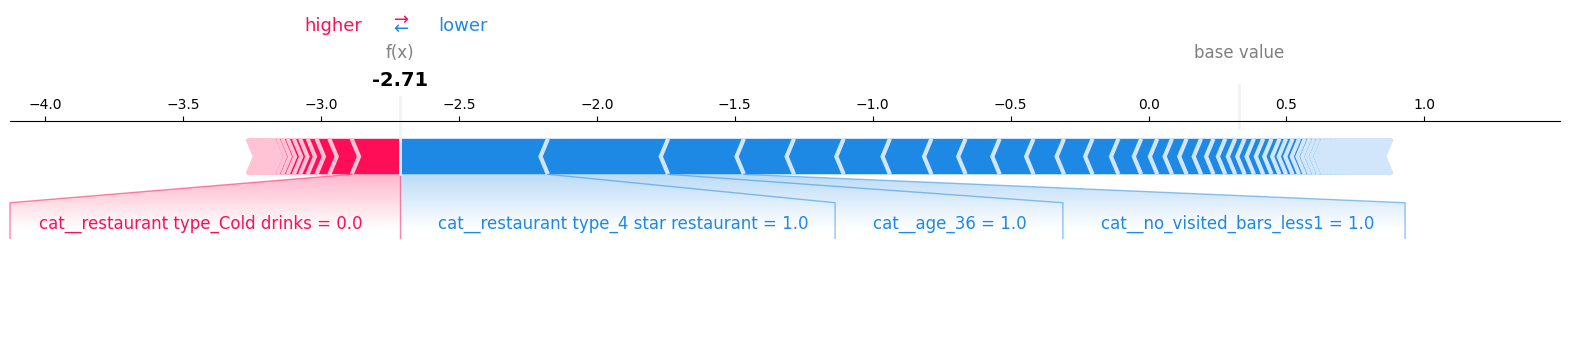

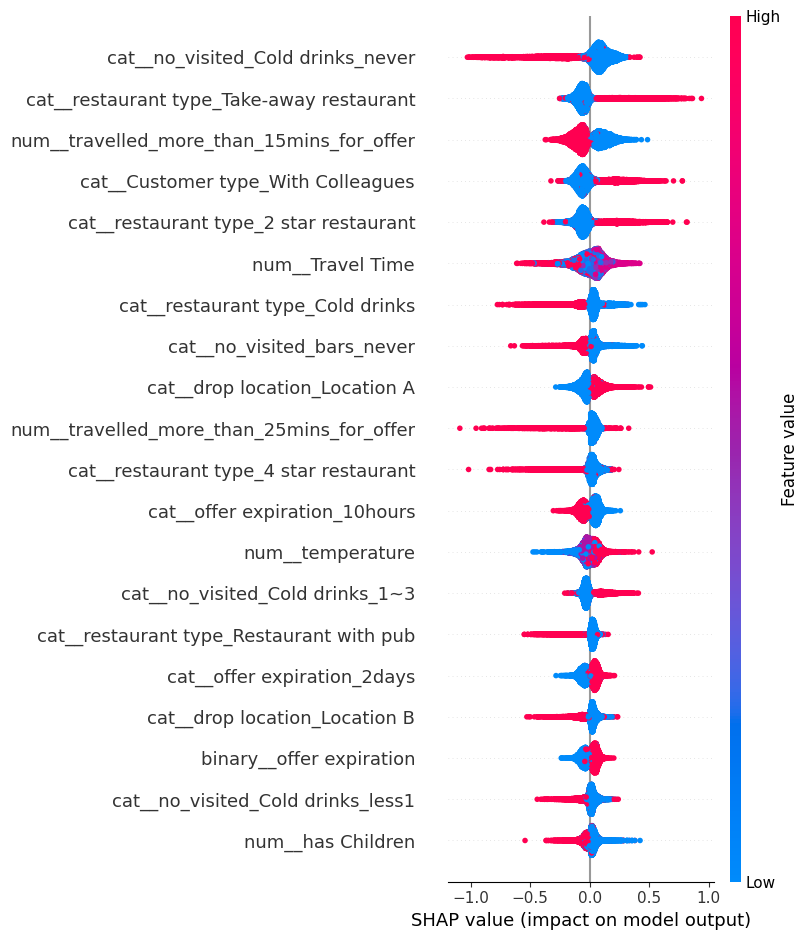

In [134]:
plt.figure(figsize=(5, 50))
shap.summary_plot(shap_values, X_full_transformed_df)
plt.savefig('./shap-analysis/summary_plot.png', dpi=300, bbox_inches='tight')
# plt.close()


In [135]:
type(shap_values), type(X_full_transformed_df)
len(shap_values), len(shap_values[0])
X_full_transformed_df.shape

(12379, 123)

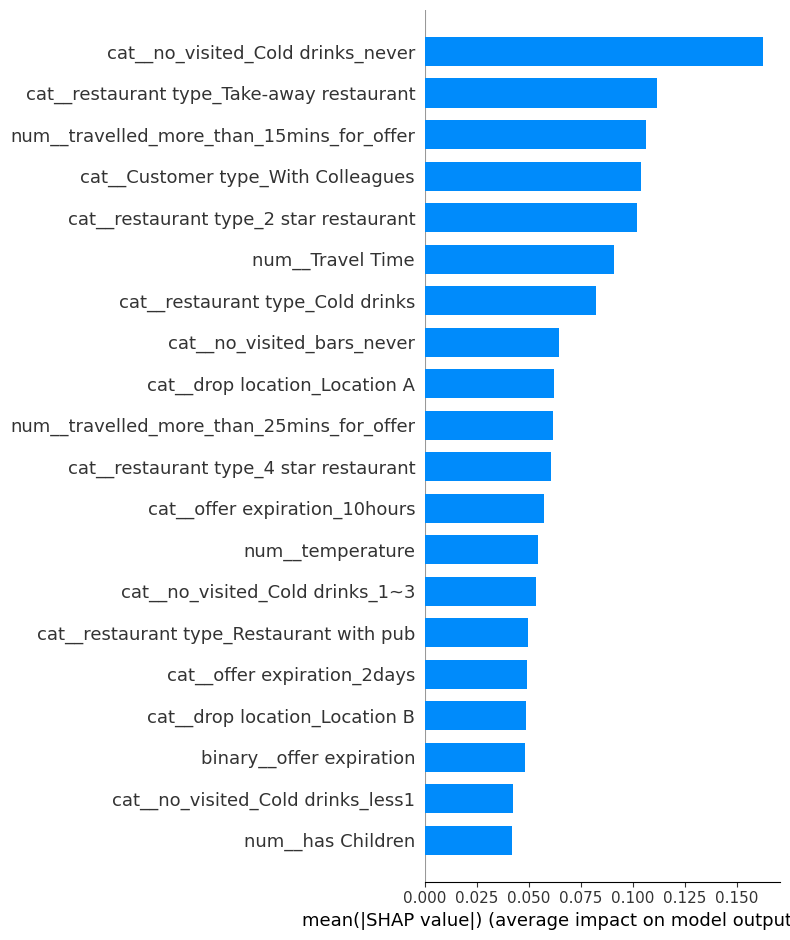

In [136]:
shap.summary_plot(shap_values, X_full_transformed_df, plot_type="bar")
plt.savefig('./shap-analysis/bar_plot.png')
plt.close()


- Create Business Strategy File

- Load PKL model file and Predict

In [182]:
# Path to the model pickle file
model_path = './models/final_xgb_model.pkl'

# Loading the trained model
model = joblib.load(model_path)

# Extracting the columns (excluding the target variable)
columns = df.columns[:-1]

# Creating an empty DataFrame with the same columns
input_data = pd.DataFrame(columns=columns)

Known_values = {
    'offer expiration': '2days',  #2days #10hours
#     'income_range': '₹75000 - ₹87499',  #'₹25000 - ₹37499' #'₹50000 - ₹62499'
#     'no_visited_Cold drinks': 'never',
#     'travelled_more_than_15mins_for_offer': 1,
#     'Restaur_spend_less_than20': '4~8', #'less1'
#     'Marital Status': 'Single',     #'Married partner',
#     'restaurant type': 'Cold drinks',  #2 star restaurant  #Take-away restaurant
#     'age': '31',    #'31' #'26' #'bellow21'
#     'Prefer western over chinese': 1,
#     'travelled_more_than_25mins_for_offer': 1,
#     'travelled_more_than_5mins_for_offer': 1,
#     'no_visited_bars': 'less1',
#     'gender': 'Male',
#     'car': 'Scooter and motorcycle',
#     'restuarant_same_direction_house': 1,
#     'Cooks regularly': 1,
#     'Customer type': 'With Colleagues',    #With Kids
#     'Qualification': 'High School Graduate',   #High School Graduate   #Associates degree
#     'is foodie': 1,
#     'no_Take-aways': 'less1',   #'gt8',
#     'Job/Job Industry': 'Protective Service',   #Protective Service #Management
#     'restuarant_opposite_direction_house': 1,
#     'has Children': 5,  #1
#     'visit restaurant with rating (avg)': 4,
#     'temperature': 67,
#     'Restaur_spend_greater_than20': 'less1',    # 'never',
    'Travel Time': 7,
#     'Climate': 'Summer',
    'drop location': 'Location A',
    'Prefer home food': 0
}

# Inserting a new row with known values and keeping other columns as null
input_data.loc[0] = [known_values.get(col, np.nan) for col in columns]
# Making a prediction based on the input data
prediction_result = model.predict(input_data)
prediction_result[0]

0

In [177]:
# Path to the model pickle file
model_path = './models/final_xgb_model.pkl'

# Loading the trained model
model = joblib.load(model_path)

# Extracting the columns (excluding the target variable)
columns = df.columns[:-1]

# Creating an empty DataFrame with the same columns
input_data = pd.DataFrame(columns=columns)

Known_values = {
    'offer expiration': '2days',  #2days #10hours
    'income_range': '₹75000 - ₹87499',  #'₹25000 - ₹37499' #'₹50000 - ₹62499'
    'no_visited_Cold drinks': 'never',
    'travelled_more_than_15mins_for_offer': 1,
    'Restaur_spend_less_than20': '4~8', #'less1'
    'Marital Status': 'Single',     #'Married partner',
    'restaurant type': 'Cold drinks',  #2 star restaurant  #Take-away restaurant
    'age': '31',    #'31' #'26' #'bellow21'
    'Prefer western over chinese': 1,
    'travelled_more_than_25mins_for_offer': 1,
    'travelled_more_than_5mins_for_offer': 1,
    'no_visited_bars': 'less1',
    'gender': 'Male',
    'car': 'Scooter and motorcycle',
    'restuarant_same_direction_house': 1,
    'Cooks regularly': 1,
    'Customer type': 'With Colleagues',    #With Kids
    'Qualification': 'High School Graduate',   #High School Graduate   #Associates degree
    'is foodie': 1,
    'no_Take-aways': 'less1',   #'gt8',
    'Job/Job Industry': 'Protective Service',   #Protective Service #Management
    'restuarant_opposite_direction_house': 1,
    'has Children': 5,  #1
    'visit restaurant with rating (avg)': 4,
    'temperature': 67,
    'Restaur_spend_greater_than20': 'less1',    # 'never',
    'Travel Time': 7,
    'Climate': 'Summer',
    'drop location': 'Location A',
    'Prefer home food': 1
}

# Inserting a new row with known values and keeping other columns as null
input_data.loc[0] = [known_values.get(col, np.nan) for col in columns]
# Making a prediction based on the input data
prediction_result = model.predict(input_data)
prediction_result[0]

0

In [174]:
# Path to the model pickle file
model_path = './models/final_xgb_model.pkl'

# Loading the trained model
model = joblib.load(model_path)

# Extracting the columns (excluding the target variable)
columns = df.columns[:-1]

# Creating an empty DataFrame with the same columns
input_data = pd.DataFrame(columns=columns)

# Known values
known_values = {
    'offer expiration': '10hours',
    'income_range': '₹50000 - ₹62499',
    'no_visited_Cold drinks': 'never',
    'travelled_more_than_15mins_for_offer': 1,
    'Restaur_spend_less_than20': '',
    'Marital Status': 'Unmarried partner',
    'restaurant type': '2 star restaurant',
    # 'restaurant type': 'Cold drinks',
    'age': 'below21',
    'Prefer western over chinese': 0,
    # 'travelled_more_than_25mins_for_offer': 0,
    'travelled_more_than_25mins_for_offer': 1,
    'travelled_more_than_5mins_for_offer': 1,
    'no_visited_bars': 'never',
    'gender': 'Female',
    'car': 'Scooter and motorcycle',
    'restuarant_same_direction_house': 0,
    'Cooks regularly': 0,
    'Customer type': 'With Kids',
    'Qualification': 'Graduate degree (Masters or Doctorate)',
    'is foodie': 0,
    'no_Take-aways': 'less1',
    'Job/Job Industry': 'Community & Social Services',
    'restuarant_opposite_direction_house': 1,
    # 'restuarant_opposite_direction_house': 0,
    'has Children': 0,
    'visit restaurant with rating (avg)': 2,
    'temperature': 89,
    'Restaur_spend_greater_than20': '4~8',
    # 'Travel Time': 7,
    'Travel Time': 22,
    'Climate': 'Summer',
    'drop location': 'Location B',
    'Prefer home food': 1
}
# Inserting a new row with known values and keeping other columns as null
input_data.loc[0] = [known_values.get(col, np.nan) for col in columns]
# Making a prediction based on the input data
prediction_result = model.predict(input_data)
prediction_result[0]

0